In [17]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error

# --- CONFIGURATION ---
# Force CPU for TensorFlow if needed (optional, depending on your setup)


FOLDER_PATH = "/home/juan/Work/Midterm project/splited/"
X_PATH = os.path.join(FOLDER_PATH, "X_data.npz")
Y_PATH = os.path.join(FOLDER_PATH, "Y_data.npz")
COLS_PATH = os.path.join(FOLDER_PATH, "feature_names.json")

# --- PART 1: DATA PREPARATION (Run only if NPZ files don't exist) ---
if not os.path.exists(X_PATH) or not os.path.exists(Y_PATH):
    print("NPZ files not found. Starting processing of CSV files...")
    
    FILE_PATTERN = os.path.join(FOLDER_PATH, "processed_*.csv")
    files = sorted(glob.glob(FILE_PATTERN))
    print(f"Found {len(files)} processed files.")

    if len(files) == 0:
        raise FileNotFoundError("No 'processed_*.csv' files found in the directory.")

    # 1. Read first file to determine column structure
    print("Reading headers from first file...")
    first_df = pd.read_csv(files[0], nrows=5)
    cols = first_df.columns
    x_cols = [c for c in cols if c.startswith("x ")]
    y_cols = [c for c in cols if c.startswith("y ")]
    
    # Save feature names for later use (Feature Importance)
    with open(COLS_PATH, 'w') as f:
        json.dump(x_cols, f)

    print(f"Detected {len(x_cols)} Features and {len(y_cols)} Targets.")

    X_list = []
    Y_list = []

    # 2. Loop through all files and convert to Sparse
    for f in files:
        print(f"Converting: {os.path.basename(f)}")
        df = pd.read_csv(f)
        
        # Extract X (Features) & Y (Targets)
        x_data = df[x_cols].fillna(0).values.astype(np.float32)
        y_data = df[y_cols].fillna(0).values.astype(np.float32)
        
        X_list.append(sparse.csr_matrix(x_data))
        Y_list.append(sparse.csr_matrix(y_data))
        
        del df, x_data, y_data # Free RAM

    # 3. Stack and Save
    print("Stacking matrices...")
    X_final = sparse.vstack(X_list)
    Y_final = sparse.vstack(Y_list)

    print(f"Saving to {FOLDER_PATH}...")
    sparse.save_npz(X_PATH, X_final)
    sparse.save_npz(Y_PATH, Y_final)
    print("Processing complete.")

else:
    print("Found existing NPZ files. Skipping CSV processing.")

# --- PART 2: LOAD DATA & PREPARE FOR MODELING ---
print("Loading Data from disk...")
X = sparse.load_npz(X_PATH)
Y = sparse.load_npz(Y_PATH)

# Load feature names if needed later
if os.path.exists(COLS_PATH):
    with open(COLS_PATH, 'r') as f:
        feature_names = json.load(f)
else:
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]

# 1. Select Target (Most Frequent Reaction)
# Sum columns to find which reaction happens most often
col_sums = np.array(Y.sum(axis=0)).flatten()
target_idx = np.argmax(col_sums)
y_target = Y[:, target_idx].toarray().ravel()

print(f"Target Index selected: {target_idx}")
print(f"Positive Cases: {int(sum(y_target))} / {len(y_target)}")

# 2. Calculate Class Weight (for imbalanced learning)
pos_count = sum(y_target)
neg_count = len(y_target) - pos_count
scale_weight = neg_count / (pos_count + 1e-5)
print(f"Calculated Class Weight (neg/pos): {scale_weight:.2f}")

# 3. Train/Test Split
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)

# --- PART 3: EVALUATION SETUP ---
results_table = []
roc_curves = {}

def log_result(name, y_true, y_prob):
    """
    Logs MSE and AUC for a given model.
    """
    # Handle NaN values in predictions just in case
    y_prob = np.nan_to_num(y_prob)
    
    mse = mean_squared_error(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    results_table.append({"Model": name, "MSE": mse, "AUC": roc_auc})
    roc_curves[name] = (fpr, tpr, roc_auc)
    print(f"✅ {name} Finished: AUC={roc_auc:.4f}, MSE={mse:.5f}")

print("\nSetup Complete. Data is ready fZor training models.")
# You can now proceed to define and train your models (LogisticRegression, XGBoost, etc.)

Found existing NPZ files. Skipping CSV processing.
Loading Data from disk...
Target Index selected: 4309
Positive Cases: 52505 / 661276
Calculated Class Weight (neg/pos): 11.59
Splitting data...

Setup Complete. Data is ready fZor training models.


Training XGBoost...


/home/juan/Work/Midterm project/Git/Predicting-Adverse-Events-Following-Notifications-Based-on-Medicine/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:27:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-auc:0.67028
[10]	validation_0-auc:0.79001
[20]	validation_0-auc:0.79618
[30]	validation_0-auc:0.79888
[40]	validation_0-auc:0.80366
[50]	validation_0-auc:0.80623
[60]	validation_0-auc:0.80873
[70]	validation_0-auc:0.81022
[80]	validation_0-auc:0.81139
[90]	validation_0-auc:0.81257
[100]	validation_0-auc:0.81494
[110]	validation_0-auc:0.81576
[120]	validation_0-auc:0.81636
[130]	validation_0-auc:0.81691
[140]	validation_0-auc:0.81757
[150]	validation_0-auc:0.81811
[160]	validation_0-auc:0.81877
[170]	validation_0-auc:0.81964
[180]	validation_0-auc:0.82018
[190]	validation_0-auc:0.82121
[199]	validation_0-auc:0.82161
✅ XGBoost Finished: AUC=0.8216, MSE=0.16993
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.87    121590
         1.0       0.22      0.72      0.34     10666

    accuracy                           0.78    132256
   macro avg       0.60      0.75      0.60    132256
weighted avg       0.91      0.78      0.82 

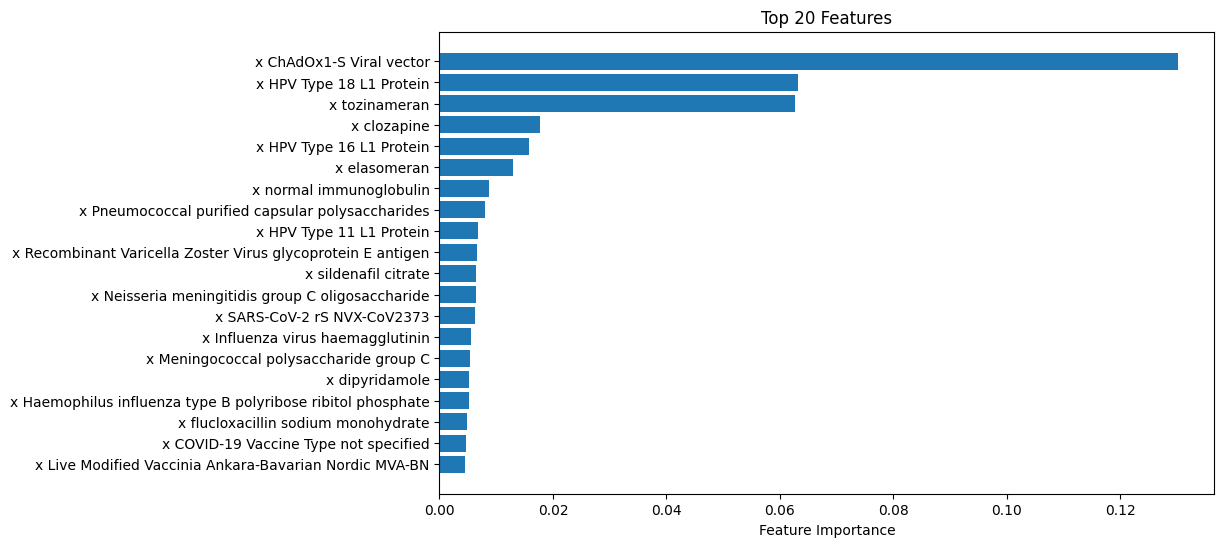

In [18]:
import xgboost as xgb
from sklearn.metrics import classification_report

# --- PART 4: XGBoost MODEL TRAINING ---
print("Training XGBoost...")

# Initialize classifier
xgb_clf = xgb.XGBClassifier(
    max_depth=6,          # typical default
    n_estimators=200,     # number of trees
    learning_rate=0.1,
    subsample=0.8,        # row sampling
    colsample_bytree=0.8, # feature sampling
    scale_pos_weight=scale_weight,  # handle class imbalance
    use_label_encoder=False,
    eval_metric='auc',
    tree_method='hist',   # fast on CPU for large sparse data
    n_jobs=-1,
    random_state=42
)

# Train
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=10)

# Predict probabilities
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# Log results
log_result("XGBoost", y_test, y_prob)

# Optional: Print classification report
y_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))

# Optional: Feature importance plot
importances = xgb_clf.feature_importances_
top_idx = np.argsort(importances)[::-1][:20]  # top 20 features

plt.figure(figsize=(10,6))
plt.barh(range(len(top_idx)), importances[top_idx][::-1], tick_label=[feature_names[i] for i in top_idx[::-1]])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features")
plt.show()


In [5]:
from sklearn.linear_model import LogisticRegression
print("--- Training Ridge (Logistic L2) ---")
# class_weight='balanced' uses the inverse frequency automatically
ridge = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced')
ridge.fit(X_train, y_train)

# Predict Probabilities (column 1 is the probability of class '1')
preds = ridge.predict_proba(X_test)[:, 1]
log_result("Ridge", y_test, preds)

--- Training Ridge (Logistic L2) ---
✅ Ridge Finished: AUC=0.8040, MSE=0.18192


In [6]:
print("--- Training Lasso (Logistic L1) ---")
lasso = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
lasso.fit(X_train, y_train)

preds = lasso.predict_proba(X_test)[:, 1]
log_result("Lasso", y_test, preds)

--- Training Lasso (Logistic L1) ---
✅ Lasso Finished: AUC=0.8039, MSE=0.18190


In [7]:
from sklearn.ensemble import RandomForestClassifier
print("--- Training Random Forest ---")
# Limited depth to prevent OOM, n_jobs=-1 for speed
rf = RandomForestClassifier(n_estimators=50, max_depth=15, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)

preds = rf.predict_proba(X_test)[:, 1]
log_result("Random Forest", y_test, preds)

--- Training Random Forest ---
✅ Random Forest Finished: AUC=0.7838, MSE=0.22222


In [19]:
print("--- Training XGBoost ---")
# scale_pos_weight manually sets the penalty for the positive class
xgb_model = xgb.XGBClassifier(
    n_estimators=100, 
    scale_pos_weight=scale_weight, 
    eval_metric='logloss',
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

preds = xgb_model.predict_proba(X_test)[:, 1]
log_result("XGBoost", y_test, preds)

--- Training XGBoost ---
✅ XGBoost Finished: AUC=0.8232, MSE=0.16814


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("--- Training PyTorch (Deep NN) ---")

# 1. Dataset
class TorchDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        # Convert sparse row to dense tensor
        return torch.tensor(self.X[i].toarray(), dtype=torch.float32).squeeze(), self.y[i]

train_dl = DataLoader(TorchDS(X_train, y_train), batch_size=64, shuffle=True)
test_dl = DataLoader(TorchDS(X_test, y_test), batch_size=64, shuffle=False)

# 2. Deep Architecture
class DeepDrugNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepDrugNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),         # Prevent overfitting
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)         # Output Logits
        )
    def forward(self, x):
        return self.net(x)

# 3. Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt = DeepDrugNet(X.shape[1]).to(device)

# Weighted Loss
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scale_weight]).to(device))
optimizer = optim.Adam(model_pt.parameters(), lr=0.0005) # Lower LR for deep net

# 4. Train
model_pt.train()
for epoch in range(5): # Increased epochs for deep net
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model_pt(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_dl):.4f}")

# 5. Predict
model_pt.eval()
pt_preds = []
with torch.no_grad():
    for xb, _ in test_dl:
        xb = xb.to(device)
        # Apply Sigmoid here because model outputs Logits
        pt_preds.extend(torch.sigmoid(model_pt(xb)).cpu().numpy().flatten().tolist())

log_result("Neuron Network", y_test, np.array(pt_preds))

--- Training PyTorch (Deep NN) ---
Epoch 1 Loss: 1.0139
Epoch 2 Loss: 0.9767
Epoch 3 Loss: 0.9672
Epoch 4 Loss: 0.9609
Epoch 5 Loss: 0.9561
✅ Neuron Network Finished: AUC=0.8101, MSE=0.16035


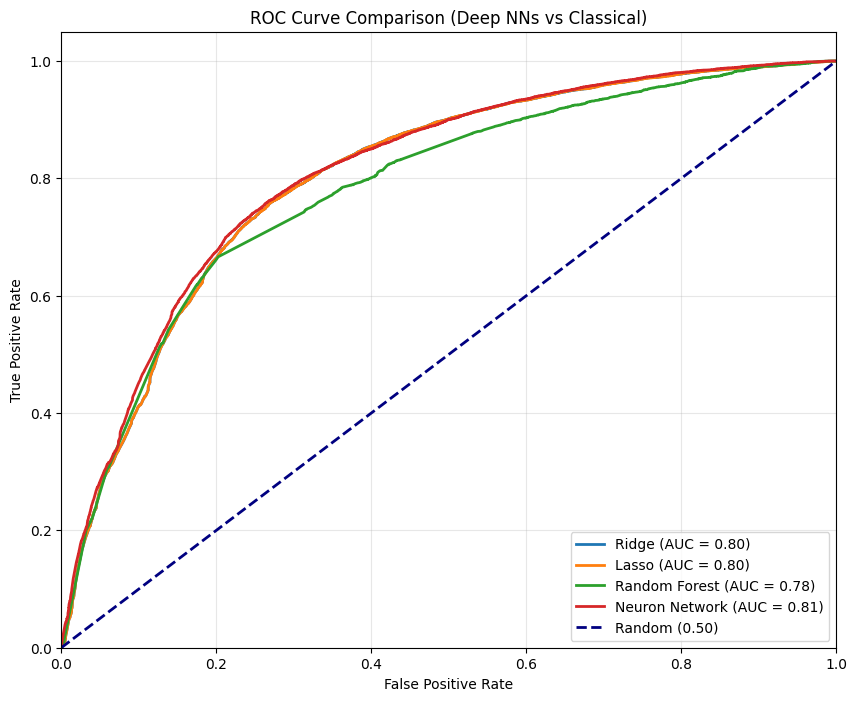

In [14]:

res_df = pd.DataFrame(results_table).sort_values(by="AUC", ascending=False)

res_df.to_csv(os.path.join(FOLDER_PATH, "final_deep_results.csv"), index=False)

plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Deep NNs vs Classical)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
Y

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1652565 stored elements and shape (661276, 10488)>

In [16]:
X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2661481 stored elements and shape (661276, 5285)>